# Implementing Fast Fourier Transform(FFT) Using Python

## Table of Contents
* [Introduction](#Introduction)
* [Python Implementation](#Implementation)
* [Testing the Code and Comparing with DFT](#Testing)

<a name="Introduction"></a>

## Introduction

A [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm computes the Discrete Fourier transform (DFT) of a sequence, or its inverse (IFFT) in a very fast and efficient way. Fourier analysis converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.

An FFT rapidly computes such transformations by factorizing the DFT matrix into a product of sparse (mostly zero) factors. As a result, it manages to reduce the complexity of computing the DFT from $O(n^{2})$, which arises if one simply applies the definition of DFT, to $O(n\log n)$, where $n$ is the data size.

You can refer the mathematical computation (formula) of FFT from [here](https://en.wikipedia.org/wiki/Fast_Fourier_transform), [here](http://cnx.org/contents/G9Br4_Zf@22/Fast-Fourier-Transform-FFT) and [here](http://fourier.eng.hmc.edu/e101/lectures/Image_Processing/node5.html)

Fast Fourier Transform (FFT) is a fast way of implementing a DFT. The results of FFT and DFT are exactly the same but FFT is much faster.

The forward transform is computed as follows (assume $M = \frac{N}{2}$):

$F(u,v) = \frac{1}{4}[F_{ee}(u,v) + F_{eo}(u,v)W_N^v + F_{oe}(u,v)W_N^u + F_{oo}W_N^{u+v}]$ for $u,v=0,1,...,M$

$F(u,v+M) = \frac{1}{4}[F_{ee}(u,v) - F_{eo}(u,v)W_N^v + F_{oe}(u,v)W_N^u - F_{oo}W_N^{u+v}]$

$F(u+M,v) = \frac{1}{4}[F_{ee}(u,v) + F_{eo}(u,v)W_N^v - F_{oe}(u,v)W_N^u - F_{oo}W_N^{u+v}]$

$F(u+M,v+M) = \frac{1}{4}[F_{ee}(u,v) - F_{eo}(u,v)W_N^v - F_{oe}(u,v)W_N^u + F_{oo}W_N^{u+v}]$

Where, 

$F_{ee}(u,v) = \frac{1}{N^2}\sum_{x=0}^{\frac{N}{2}-1}\sum_{y=0}^{\frac{N}{2}-1}f(2x,2y) W_{\frac{N}{2}}^{ux+vy}$

$F_{eo}(u,v) = \frac{1}{N^2}\sum_{x=0}^{\frac{N}{2}-1}\sum_{y=0}^{\frac{N}{2}-1}f(2x,2y+1) W_{\frac{N}{2}}^{ux+vy}$

$F_{oe}(u,v) = \frac{1}{N^2}\sum_{x=0}^{\frac{N}{2}-1}\sum_{y=0}^{\frac{N}{2}-1}f(2x+1,2y) W_{\frac{N}{2}}^{ux+vy}$

$F_{oo}(u,v) = \frac{1}{N^2}\sum_{x=0}^{\frac{N}{2}-1}\sum_{y=0}^{\frac{N}{2}-1}f(2x+1,2y+1) W_{\frac{N}{2}}^{ux+vy}$

$W_N^{ux} = e^\frac{-j2\pi ux}{N}$

<a name="Implementation"></a>
## Python Implementation

Import the python packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib.image as img
import PIL.Image as Image 

import math
import cmath

import time

import csv

from numpy import binary_repr


Before we implement FFT, let's first define functions for the common image manipulations.

In [2]:
def generateBlackAndWhiteSquareImage(imgSize):
    """
    Generates a square-sized black and white image with a given input size.

    Parameters
    ----------
    imgSize : int
        Input number that stores the dimension of the square image to be generated.

    Returns
    -------
    imge : ndarray
        The generated black and white square image.
    """

    #Creating a matrix with a given size where all the stored values are only zeros (for initialization)
    imge = np.zeros([imgSize, imgSize], dtype=int)

    #Starting and ending indices of the white part of the image.
    ind1 = imgSize/4
    ind2 = ind1 + (imgSize/2)

    #Make a part of the image as white (255)
    imge[ind1:ind2, ind1:ind2] = np.ones([imgSize/2, imgSize/2], dtype=int)*255

    #return the resulting image
    return imge
    
def generateImagesWithResizedWhite(imge):
    """
    Generates images with the same size as the original but with a resized white part of them.
    """

    N = imge.shape[0]

    imges = []
    i = N/2
    while i >= 4:
        j = (N - i)/2

        #Starting and ending indices for the white part.
        indx1 = j
        indx2 = j+i

        #Draw the image.
        imgeNew = np.zeros([N, N],dtype=int)
        imgeNew[indx1:indx2, indx1:indx2] = np.ones([i, i], dtype=int)*255

        #Add the image to the list.
        imges.append(imgeNew)

        i = i/2

    return imges

def resizeImage(imge, newSize):        
    """
    Reduces the size of the given image.

    Parameters
    ----------
    imge : ndarray
        Input array that stores the image to be resized.

    Returns
    -------
    newSize : int
        The size of the newly generated image.
    """

    #Compute the size of the original image (in this case, only # of rows as it is square)
    N = imge.shape[0]

    #The ratio of the original image as compared to the new one.
    stepSize = N/newSize

    #Creating a new matrix (image) with a black color (values of zero)
    newImge = np.zeros([N/stepSize, N/stepSize])

    #Average the adjacent four pixel values to compute the new intensity value for the new image.
    for i in xrange(0, N, stepSize):
        for j in xrange(0, N, stepSize):
            newImge[i/stepSize, j/stepSize] = np.mean(imge[i:i+stepSize, j:j+stepSize])

    #Return the new image
    return newImge

def generateImages(imgSizes=[128, 64, 32, 16, 8]): 
    """
    Generates images with different sizes
    """
    #Create an empty list of images to save the generated images with different sizes.
    images = []

    #Generate the first and biggest image
    imge = generateBlackAndWhiteSquareImage(imgSizes[0])

    #Add to the images list
    images.append(imge)

    #Generate the resized and smaller images with different sizes.
    for i in range(1, len(imgSizes)):
        size = imgSizes[i]
        images.append(resizeImage(imge, size))
        
    return images

As a next step, we will implement 2D DFT. You can refer its details on other DFT post.

In [3]:
class DFT(object):
    """
    This class DFT implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (Forward DFT Transform)
    """
    
    @classmethod
    def __computeConjugate(self, mat):
        """
        Computes the conjugate of a complex square-matrix.

        Parameters
        ----------
        mat : ndarray
            Input matrix of complex numbers.

        Returns
        -------
        result : ndarray
            The conjugate of the input matrix.
        """
        
        N = mat.shape[0]
        result = np.zeros([N, N], dtype=np.complex)
        
        for i in range(N):
            for j in range(N):
                result[i, j] = (mat[i, j].real) - (mat[i, j].imag*1j)

        return result
    
    @classmethod
    def __multiplyMatrices(self, mat1, mat2):
        """
        Computes the multiplication of two complex square matrices.

        Parameters
        ----------
        mat1 : ndarray
            First input matrix of complex numbers.
        mat2 : ndarray
            Second input matrix of complex numbers.
            
        Returns
        -------
        result : ndarray
            The multiplication result of the two matrices.
        """
        
        N = mat1.shape[0]
        
        result = np.zeros([N, N], np.complex)
        #For each column and row...
        for i in range(N):
            row = mat1[i, :]
            for j in range(N):
                col = mat2[j, :]
                total = 0 + 0j
                for k in range(N):
                    total += row[k]*col[k]
                result[i, j] = total
        
        return result
        
    #Compute the two separable kernels for the forward DFT.
    @classmethod
    def computeXForwardKernel(self, size):
        """
        Computes/generates the first forward kernel function.

        Parameters
        ----------
        size : int
            Size of the kernel to be generated.

        Returns
        -------
        xKernel : ndarray
            The generated kernel as a matrix.
        """
        
        #Initialize the kernel
        xKernel = np.zeros([size, size], dtype=np.complex)
        
        #Compute each value of the kernel...
        for u in range(size):
            for x in range(size):
                
                #Rounding it is used here for making the values integers as it will insert very small fractions.
                xKernel[u, x] = math.cos((2*math.pi*u*x)/size) - (1j*math.sin((2*math.pi*u*x)/size))
        
        #Return the resulting kernel
        return xKernel

    @classmethod
    def computeYForwardKernel(self, xKernel):
        """
        Computes/generates the second forward kernel function.

        Parameters
        ----------
        xKernel : ndarray
            The first forward kernel function.

        Returns
        -------
        yKernel : ndarray
            The generated kernel as a matrix.
        """
        #yKernel = np.conj(xKernel) ## In numpy package.
        N = xKernel.shape[0]
        
        #For each value, find the conjugate...
        yKernel = np.zeros([N, N], dtype=np.complex)
        for i in range(N):
            for j in range(N):
                yKernel[i, j] = (xKernel[i, j].real) - (xKernel[i, j].imag*1j)
                
        # Return the resulting kernel (Since the original kernel is symmetric, transpose is not needed)
        return yKernel
    
    @classmethod
    def computeCenteredImage(self, imge):
        """
        Centers a given image.

        Parameters
        ----------
        imge : ndarray
            Input array that stores the image to be centered.

        Returns
        -------
        newImge : int
            The new and centered version of the input image.
        """
        
        #Compute the dimensions of the image
        M, N = imge.shape
        #centeringMatrix = np.zeros([M, N], dtype=int)
        newImge = np.zeros([M, N], dtype=int)
        for x in range(M):
            for y in range(N):
                newImge[x, y] = imge[x, y] * ((-1)**(x+y))

        #newImge = imge * centeringMatrix
        return newImge
    
    @classmethod
    def computeForward2DDFTWithSeparability(self, imge):
        """
        Computes/generates the 2D DFT by computing the two forward kernels first (Separability).

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
        
        N = imge.shape[0]
        xKernel = DFT.computeXForwardKernel(N)
        yKernel = DFT.computeYForwardKernel(xKernel)

        #row1DDFT = (1.0/size) * np.dot(xKernel, imge)
        intermediate2DDFT = (1.0/N) * DFT.__multiplyMatrices(xKernel, imge)
        final2DDFT = (1.0/N) * DFT.__multiplyMatrices(intermediate2DDFT, yKernel)

        return final2DDFT
        
    @classmethod
    def __computeSinglePoint2DFT(self, imge, u, v, N):
        """
        A private method that computes a single value of the 2DDFT from a given image.

        Parameters
        ----------
        imge : ndarray
            The input image.
        
        u : ndarray
            The index in x-dimension.
            
        v : ndarray
            The index in y-dimension.

        N : int
            Size of the image.
            
        Returns
        -------
        result : complex number
            The computed single value of the DFT.
        """
        result = 0 + 0j
        for x in xrange(N):
            for y in xrange(N):
                result += (imge[x, y] * (math.cos((2*math.pi*(u*x + v*y))/N) - 
                                         (1j*math.sin((2*math.pi*(u*x + v*y))/N))))
        return result
    
    @classmethod
    def computeForward2DDFTNoSeparability(self, imge):
        """
        Computes/generates the 2D DFT by computing without separating the kernels.

        Parameters
        ----------
        imge : ndarray
            The input image to be transformed.

        Returns
        -------
        final2DDFT : ndarray
            The transformed image.
        """
 
        # Assuming a square image
        N = imge.shape[0]
        final2DDFT = np.zeros([N, N], dtype=np.complex)
        for u in xrange(N):
            for v in xrange(N):
                #Compute the DFT value for each cells/points in the resulting transformed image.
                final2DDFT[u, v] = DFT.__computeSinglePoint2DFT(imge, u, v, N)
        return ((1.0/(N**2))*final2DDFT)
    
    @classmethod
    def computeInverse2DDFTWithSeparability(self, dftImge):
        """
        Computes the inverse 2D DFT by computing the two inverse kernels first (Separability).

        Parameters
        ----------
        dftImge : ndarray
            The dft transformed image as input.

        Returns
        -------
        imge : ndarray
            The resulting image in spatial domain from the inverse DFT.
        """
        
        N = dftImge.shape[0]
        
        #Here the kernels are interchanged from the forward DFT
        yKernel = DFT.computeXForwardKernel(N)
        xKernel = DFT.computeYForwardKernel(yKernel)

        intermediateImge = DFT.__multiplyMatrices(xKernel, dftImge)
        imge = DFT.__multiplyMatrices(intermediateImge, yKernel)
        
        #imge = np.real(imge)

        return imge       

    @classmethod
    def compute2DDFTFourierSpectrum(self, dftImge):
        """
        Computes the fourier spectrum of the transformed image.

        Parameters
        ----------
        dftImge : ndarray
            The input transformed image.

        Returns
        -------
        fourierSpect : ndarray
            The computed fourier spectrum.
        """
        N = dftImge.shape[0]
        
        fourierSpect = np.zeros([N, N], dtype=float)
        #Calculate the magnitude of each point(complex number) in the DFT image
        for i in xrange(N):
            for j in xrange(N):
                v = dftImge[i, j]
                fourierSpect[i, j] = math.sqrt((v.real)**2 + (v.imag)**2)
        return fourierSpect
    
    @classmethod
    def normalize2DDFTByLog(self, dftImge):
        """
        Computes the log transformation of the transformed DFT image to make the range
        of the fourier values b/n 0 to 255
        
        Parameters
        ----------
        dftImge : ndarray
            The input transformed image.

        Returns
        -------
        dftNormImge : ndarray
            The normalized version of the transformed image.
        """
        
        #Compute the fourier spectrum of the transformed image:
        dftFourierSpect = DFT.compute2DDFTFourierSpectrum(dftImge)
        
        #Normalize the fourier spectrum values:
        dftNormFourierSpect = (255.0/ math.log10(255)) * np.log10(1 + (255.0/(np.max(dftFourierSpect))*dftFourierSpect))
        
        return dftNormFourierSpect
        

<a name="Testing"></a>

The implementation of FFT is as follows:

In [4]:
class FFT(object):
    """
    This class FFT implements all the procedures for transforming a given 2D digital image
    into its corresponding frequency-domain image (FFT)
    """
    
    @classmethod
    def __computeSingleW(self, num, denom):
        """Computes one value of W from the given numerator and denominator values. """
        return math.cos((2*math.pi*num)/denom) - (1j*math.sin((2*math.pi*num)/denom))
    
    @classmethod
    def __computeW(self, val, denom, oneD=True):
        """Computes 1D or 2D values of W from the given numerator and denominator values."""
        if oneD:
            result = np.zeros([val, 1], dtype=np.complex)
            for i in xrange(val):
                result[i] = FFT.__computeSingleW(i, denom)
        else:
            result = np.zeros([val, val], dtype=np.complex)
            for i in xrange(val):
                for j in xrange(val):
                    result[i, j] = FFT.__computeSingleW((i+j), denom)
        return result
        
    @classmethod
    def computeFFT(self, imge):
        """Computes the FFT of a given image.
        """

        #Compute size of the given image
        N = imge.shape[0]

        #Compute the FFT for the base case (which uses the normal DFT)
        if N == 2:
            return DFT.computeForward2DDFTNoSeparability(imge)

        #Otherwise compute FFT recursively

        #Divide the original image into even and odd
        imgeEE = np.array([[imge[i,j] for i in xrange(0, N, 2)] for j in xrange(0, N, 2)]).T
        imgeEO = np.array([[imge[i,j] for i in xrange(0, N, 2)] for j in xrange(1, N, 2)]).T
        imgeOE = np.array([[imge[i,j] for i in xrange(1, N, 2)] for j in xrange(0, N, 2)]).T
        imgeOO = np.array([[imge[i,j] for i in xrange(1, N, 2)] for j in xrange(1, N, 2)]).T

        #Compute FFT for each of the above divided images
        FeeUV = FFT.computeFFT(imgeEE)
        FeoUV = FFT.computeFFT(imgeEO)
        FoeUV = FFT.computeFFT(imgeOE)
        FooUV = FFT.computeFFT(imgeOO)

        #Compute also Ws
        Wu = FFT.__computeW(N/2, N)
        Wv = Wu.T #Transpose
        Wuv = FFT.__computeW(N/2, N, oneD=False)

        #Compute F(u,v) for u,v = 0,1,2,...,N/2  
        imgeFuv = 0.25*(FeeUV + (FeoUV * Wv) + (FoeUV * Wu) + (FooUV * Wuv))

        #Compute F(u, v+M) where M = N/2
        imgeFuMv = 0.25*(FeeUV + (FeoUV * Wv) - (FoeUV * Wu) - (FooUV * Wuv))

        #Compute F(u+M, v) where M = N/2
        imgeFuvM = 0.25*(FeeUV - (FeoUV * Wv) + (FoeUV * Wu) - (FooUV * Wuv))

        #Compute F(u+M, v+M) where M = N/2
        imgeFuMvM = 0.25*(FeeUV - (FeoUV * Wv) - (FoeUV * Wu) + (FooUV * Wuv))

        imgeF1 = np.hstack((imgeFuv, imgeFuvM))
        imgeF2 = np.hstack((imgeFuMv, imgeFuMvM))
        imgeFFT = np.vstack((imgeF1, imgeF2))

        return imgeFFT 
    
    @classmethod
    def computeInverseFFT(self, imgeFFT):
        N = imgeFFT.shape[0]
        return np.real(np.conjugate(FFT.computeFFT(np.conjugate(imgeFFT)*(N**2)))*(N**2))

<a name="Testing"></a>
## Testing the Code and Comparing the Computation time with DFT

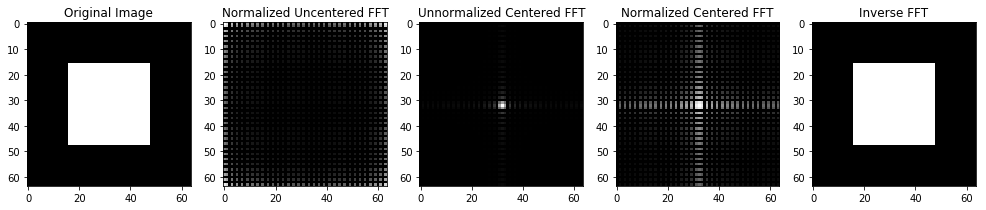

In [5]:
#For visualization:
fig, axarr = plt.subplots(1, 5, figsize=(17, 17))

#Generate an image
imge = generateBlackAndWhiteSquareImage(64)

#Center the generated image
centeredImge = DFT.computeCenteredImage(imge)

#Compute the 2D DFT transformation for both centered and uncentered images (Using FFT algorithm):
fftUncenteredImge = FFT.computeFFT(imge)
fftCenteredImge = FFT.computeFFT(centeredImge)

#Normalize the computed FFT results:
fftUncenteredNormImge = DFT.normalize2DDFTByLog(fftUncenteredImge)
fftCenteredNormImge = DFT.normalize2DDFTByLog(fftCenteredImge)

#Compute the inverse using Forward FFT (Reference: https://www.dsprelated.com/showarticle/800.php Method #4)
invImgeCentered = FFT.computeInverseFFT(fftCenteredImge)
invImge = DFT.computeCenteredImage(invImgeCentered)

#Display the normalized versions of the centered and uncentered images
axarr[0].imshow(imge, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
axarr[0].set_title('Original Image')

axarr[1].imshow(fftUncenteredNormImge, cmap=plt.get_cmap('gray'))
axarr[1].set_title('Normalized Uncentered FFT')

axarr[2].imshow(DFT.compute2DDFTFourierSpectrum(fftCenteredImge), cmap=plt.get_cmap('gray'))
axarr[2].set_title('Unnormalized Centered FFT')

axarr[3].imshow(fftCenteredNormImge, cmap=plt.get_cmap('gray'))
axarr[3].set_title('Normalized Centered FFT')

axarr[4].imshow(invImge, cmap=plt.get_cmap('gray'))
axarr[4].set_title('Inverse FFT')

plt.show()

Now let's compare the FFT running time with that of DFT by computing the transformation for different images

In [6]:
#Generate images
imgSizes = [128, 64, 32, 16, 8]
images = generateImages(imgSizes)

# A list that stores the running time of the DFT algorithm for images with different size.
runningTimeFFT = []

#For each image...
for i, imge in enumerate(images):
    
    #Compute the image size
    N = imge.shape[0]
    
    print "Computing for ", N, "x", N, "image..."
    
    #Step 1: Center the image
    centeredImge = DFT.computeCenteredImage(imge)

    #Save the starting time.
    startTime = time.time()

    #Step 2: Compute the DFT of the image using the matrix multiplication form. 
    fftImge = FFT.computeFFT(centeredImge)
    
    #Save the running time
    runningTimeFFT.append((time.time() - startTime)/60.00)

Computing for  128 x 128 image...
Computing for  64 x 64 image...
Computing for  32 x 32 image...
Computing for  16 x 16 image...
Computing for  8 x 8 image...


In [7]:
#Save results to text file
result = zip(imgSizes, runningTimeFFT)
np.savetxt("RunningTimes/runningTimeFFT.csv", np.array(result), delimiter=',')

In [8]:
#Load the running time for DFT and FFT Transforms.
#N.B runningTimeDFT.csv was saved when running the DFT algorithm in the other section
runningTimeDFT = np.loadtxt("RunningTimes/runningTimeDFT.csv", delimiter =',')
runningTimeFFT = np.loadtxt("RunningTimes/runningTimeFFT.csv", delimiter =',')

['128x128', '64x64', '32x32', '16x16', '8x8']


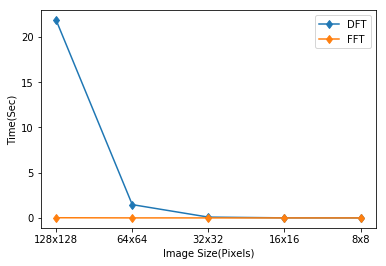

In [9]:
#Plot the running times
plt.plot(xrange(runningTimeDFT.shape[0]), runningTimeDFT[:,1], '-d')
plt.hold
plt.plot(xrange(runningTimeFFT.shape[0]), runningTimeFFT[:,1], '-d')

xlabels = [str(int(imge)) + 'x' + str(int(imge)) for imge in runningTimeDFT[:, 0]]
print xlabels
plt.xticks(xrange(len(runningTimeDFT[:, 0])), xlabels)
plt.xlabel("Image Size(Pixels)")
plt.ylabel("Time(Sec)")
plt.legend(['DFT', 'FFT'])
plt.show()

As we can see from the above comparison graph, FFT is much faster than DFT.